<a href="https://colab.research.google.com/github/bukhtiarhaider/CE888/blob/main/JOBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
!pip install econml

In [176]:
!pip install xgboost

In [177]:
%matplotlib inline
from xgboost import XGBRegressor, XGBClassifier
from econml.metalearners import XLearner
from econml.dr import  DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from google.colab import files
import warnings
warnings.filterwarnings(action='ignore')

In [178]:
# Load the data
dfraw = pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv')
dfraw.head() # Just taking a quick look at the data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0


# **DATA CLEANING**


Categorical Encoding

In [179]:
class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [180]:
le = LabelEncoder()
dfraw['y'] = le.fit_transform(dfraw['y'])

dfraw['e'] = le.fit_transform(dfraw['e'])

Train/Test Split

In [181]:
df_train, df_test = train_test_split(dfraw, test_size=0.2, stratify=dfraw['t'], random_state = 10)

Over Sampling


In [182]:
smote_oversample = SMOTE()
t = df_train['t']
print(Counter(t))
df_train = df_train.drop('t', axis = 1)
df_train, t = smote_oversample.fit_resample(df_train, t)
print(Counter(t))

Counter({0.0: 2331, 1.0: 238})
Counter({1.0: 2331, 0.0: 2331})


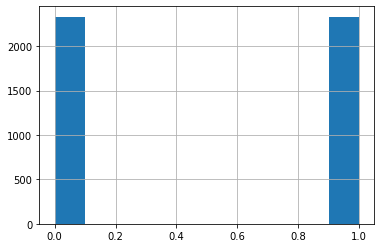

In [183]:
df_train['t'] = t
df_train['t'].hist(bins=10)

In [184]:
y_train = df_train['y']
e_train = df_train['e']
t_train = df_train['t']
x_train = df_train.drop(['t', 'y', 'e'], axis = 1)

y_test = df_test['y']
e_test = df_test['e']
t_test = df_test['t']
x_test = df_test.drop(['t', 'y', 'e'], axis = 1)

In [185]:
#print((len(ite_train)*np.mean(ite_train) + len(ite_test)*np.mean(ite_test))/(len(ite_train)+len(ite_test)))
#print(np.mean(dfraw['ite']))
#print(np.mean(ite_test))

**Feature** **Selection**

In [186]:
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select = 15)
fit = rfe.fit(pd.concat((pd.concat((x_train, x_test), axis = 0), pd.concat((t_train, t_test), axis = 0)), axis = 1), pd.concat((y_train, y_test), axis = 0))
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))


Num Features: 15
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 4 1]


In [187]:
features = []
for i in range (len(fit.support_)):
  if(fit.ranking_[i]==1):
    #Retrieve selected column names
    col = pd.concat((x_train, t_train), axis = 1).columns[i]
    if(col!='t'):
      features.append(col)
print("Selected Features: ", features)


Selected Features:  ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x16']


In [188]:
x_train = x_train[features]
x_test = x_test[features]
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
t_train = t_train.values.reshape(-1, 1)
t_test = t_test.values.reshape(-1, 1)

**Train/Test Split**

In [189]:
#x_train, x_test, t_train, t_test, y_train, y_test, ycf_train, ycf_test, ite_train, ite_test = train_test_split(x, t, y, ycf, ite, test_size=0.2, stratify=t, random_state = 0)
folds = 10
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

In [190]:
#print(e_train.shape)
#print(type(e_train))
#print(y_train[1 - t_train + e_train.values.flatten()] > 1)

In [191]:
def abs_att(effect_pred, yf, t, e):
  
    att_true = np.mean(yf[t > 0]) - np.mean(yf[(1 - t + e) > 1])
    att_pred = np.mean(effect_pred[(t + e) > 1])

    return np.abs(att_pred - att_true)

In [192]:
def policy_risk(effect_pred, yf, t, e):
    """
    Computes the risk of the policy defined by predicted effect
    :param effect_pred: predicted treatment effect value
    :param yf: factual (observed) outcome
    :param t: treatment status (treated/control)
    :param e: whether belongs to the experimental group
    :return: policy risk
    """
    # Consider only the cases for which we have experimental data (i.e., e > 0)
    t_e = t[e > 0]
    yf_e = yf[e > 0]
    effect_pred_e = effect_pred[e > 0]

    if np.any(np.isnan(effect_pred_e)):
        return np.nan

    policy = effect_pred_e > 0.0
    treat_overlap = (policy == t_e) * (t_e > 0)
    control_overlap = (policy == t_e) * (t_e < 1)

    if np.sum(treat_overlap) == 0:
        treat_value = 0
    else:
        treat_value = np.mean(yf_e[treat_overlap])

    if np.sum(control_overlap) == 0:
        control_value = 0
    else:
        control_value = np.mean(yf_e[control_overlap])

    pit = np.mean(policy)
    policy_value = pit * treat_value + (1.0 - pit) * control_value

    return 1.0 - policy_value

In [193]:
print(y_test.shape)

(643, 1)


In [194]:
#unique, counts = np.unique(y_train[t_train == 0], return_counts=True)
#dict(zip(unique, counts))
y_train[(1 - t_train.flatten() + e_train) == 0]

array([], shape=(0, 1), dtype=int64)

**SIMPLE REGRESSION**


In [195]:
scores_sl = []

xt_train = np.concatenate((x_train, t_train), axis = 1)
ytrainflat = y_train.flatten()
ttrainflat = t_train.flatten()
ttestflat = t_test.flatten()
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(xt_train, ytrainflat)

for train_index, test_index in skf.split(xt_train, t_train):
  gbr = GradientBoostingClassifier(n_estimators = 100, subsample=1, min_samples_split=15, min_samples_leaf=15, random_state=10)
  #gbr = GaussianNB()
  #gbr = RandomForestRegressor(n_estimators = 1000, min_samples_split=15, min_samples_leaf=15)
  #gbr = XGBRegressor(max_depth = 6)
  xttrain, xttest = xt_train[train_index], xt_train[test_index]
  ytrain, ytest = ytrainflat[train_index], ytrainflat[test_index]
  xtrain, xtest = x_train[train_index], x_train[test_index]
  ttrain, ttest = t_train[train_index], t_train[test_index]
  etrain, etest = e_train[train_index], e_train[test_index]


  gbr.fit(xttrain, ytrain)


  rf_test = gbr.predict(xttest)

  xt0_test = np.concatenate((xtest, np.zeros_like(ttest)), axis = 1)
  xt1_test = np.concatenate((xtest, np.ones_like(ttest)), axis = 1)
  y_t0 = gbr.predict(xt0_test)
  y_t1 = gbr.predict(xt1_test)
  avg_pred_eff = y_t1 - y_t0

  #print(f1_score(ytest, rf_test))
  err_att_score= abs_att(avg_pred_eff, ytest, ttest.flatten(), etest)
  print(err_att_score)

  scores_sl.append(err_att_score)

print("CrossVal Score: ", np.mean(scores_sl))

gbr = GradientBoostingClassifier(n_estimators = 100, subsample=1, min_samples_split=15, min_samples_leaf=15, random_state=10)
#gbr = RandomForestRegressor(n_estimators = 400, min_samples_split=15, min_samples_leaf=15)
#gbr = XGBRegressor(max_depth = 6)

gbr.fit(xt_train, ytrainflat)

xt0_test = np.concatenate((x_test, np.zeros_like(t_test)), axis = 1)
xt1_test = np.concatenate((x_test, np.ones_like(t_test)), axis = 1)
y_t0 = gbr.predict(xt0_test)
y_t1 = gbr.predict(xt1_test)
avg_pred_eff_sl = y_t1 - y_t0

#print(f1_score(y_test, rf_te_test))
score_sl = abs_att(avg_pred_eff_sl, y_test, ttestflat, e_test)

print("Testing Score:", score_sl)

0.016632016632016633
0.07793087869889316
0.06118631011334874
0.024946351931330525
0.017569742489270346
0.0486409155937053
0.08191293684855915
0.09954312612487883
0.033500238435860724
0.09594351377543964
CrossVal Score:  0.0557806030643303
Testing Score: 0.036610169491525374


**IPW Regression**


In [196]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi = ti/ptx + (1-ti)/(1-ptx)
  return wi

In [197]:
scores_tl = []

subsamp = 1
estimators = 200

for train_index, test_index in skf.split(xt_train, t_train):
  prop_gbr = GradientBoostingClassifier(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=1)
  xtrain, xtest = x_train[train_index], x_train[test_index]
  ttrain, ttest = t_train[train_index], t_train[test_index]
  xttrain, xttest = xt_train[train_index], xt_train[test_index]
  ytrain, ytest = ytrainflat[train_index], ytrainflat[test_index]
  etrain, etest = e_train[train_index], e_train[test_index]

  weights = get_ps_weights(prop_gbr, xtrain, ttrain)

  gbr_ipsw = GradientBoostingClassifier(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=1)

  gbr_ipsw.fit(xttrain, ytrain, sample_weight=weights)

  xt0_test = np.concatenate((xtest, np.zeros_like(ttest)), axis = 1)
  xt1_test = np.concatenate((xtest, np.ones_like(ttest)), axis = 1)
  y_t0 = gbr.predict(xt0_test)
  y_t1 = gbr.predict(xt1_test)
  avg_pred_eff = y_t1 - y_t0

  score = abs_att(avg_pred_eff, ytest, ttest.flatten(), etest)
  print(score)

  scores_tl.append(score)


print("CrossVal Score:", np.mean(scores_tl))
prop_clf = GradientBoostingClassifier(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=1)
weights = get_ps_weights(prop_clf, x_train, t_train)

rf_ipsw = GradientBoostingClassifier(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=1)

rf_ipsw.fit(xt_train, y_train.flatten(), sample_weight=weights)

xt0_test = np.concatenate((x_test, np.zeros_like(t_test)), axis = 1)
xt1_test = np.concatenate((x_test, np.ones_like(t_test)), axis = 1)
y_t0 = rf_ipsw.predict(xt0_test)
y_t1 = rf_ipsw.predict(xt1_test)
avg_pred_eff_tl = y_t1 - y_t0

score_tl = abs_att(avg_pred_eff_tl, y_test, ttestflat, e_test)
print("Testing Error: ", score_tl)



0.0038115038115038025
0.056471651231082
0.06118631011334874
0.03513948497854072
0.06048819742489267
0.014306151645207446
0.07762109135499691
0.0695002076699432
0.020624701955174032
0.12598643223037526
CrossVal Score: 0.052513573241506475
Testing Error:  0.019661016949152496


**DRLearner**


In [ ]:
scores_dr = []

estimators = 1000
subsamp = 1
state = 10
split = 15
leaf = 15
depth = 3



for train_index, test_index in skf.split(xt_train, t_train):
  #xl = XLearner(models=GradientBoostingClassifier(n_estimators=estimators, subsample=0.5, min_samples_split=split, min_samples_leaf=leaf, random_state=state), propensity_model=GradientBoostingClassifier(n_estimators=estimators, subsample=subsamp, min_samples_split=split, min_samples_leaf=leaf))
  #dr = DRLearner(model_regression=GradientBoostingRegressor(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_propensity=RandomForestClassifier(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_final=LassoCV(cv=5), random_state=state)
  dr = DRLearner(model_regression=XGBRegressor(), model_propensity=XGBClassifier(), model_final=LassoCV(cv=5), random_state=state)
  #xl = XLearner(models=XGBClassifier(max_depth = 6, random_state = 10), propensity_model=XGBClassifier(max_depth = 6, random_state = 10))
  xtrain, xtest = x_train[train_index], x_train[test_index]
  ttrain, ttest = t_train[train_index], t_train[test_index]
  ytrain, ytest = ytrainflat[train_index], ytrainflat[test_index]
  etrain, etest = e_train[train_index], e_train[test_index]

  dr.fit(ytrain, ttrain.flatten(), X=xtrain)
  dr_te_test = dr.effect(xtest)
  score =  abs_att(dr_te_test, ytest, ttest.flatten(), etest)
  print(score)
  scores_dr.append(score)


print("CrossVal Score: ", np.mean(scores_dr))
#xl = XLearner(models=XGBClassifier(max_depth = 6), propensity_model=XGBClassifier(max_depth=6))
#xl = XLearner(models=GradientBoostingClassifier(n_estimators=estimators, subsample=0.5, min_samples_split=split, min_samples_leaf=leaf, random_state=state), propensity_model=GradientBoostingClassifier(n_estimators=estimators, subsample=subsamp, min_samples_split=split, min_samples_leaf=leaf))
#dr = DRLearner(model_regression=GradientBoostingRegressor(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_propensity=RandomForestClassifier(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_final=LassoCV(cv=5), random_state=state)
dr = DRLearner(model_regression=XGBRegressor(), model_propensity=XGBClassifier(), model_final=LassoCV(cv=5), random_state=state)
dr.fit(ytrainflat, t_train.flatten(), X=x_train)

dr_te_test = dr.effect(x_test)
score_doublyrobust = abs_att(dr_te_test, y_test, ttestflat, e_test)
print("Testing Err: ", score_doublyrobust)

[10:12:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.06293982784700526
[10:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.01836693495379824
[10:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.030750958935752463
[10:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:55] WARNING: /workspace/src/objective/regre

In [199]:
# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
sl_polrisk_test = policy_risk(avg_pred_eff_sl, y_test, ttestflat, e_test)
tl_polrisk_test = policy_risk(avg_pred_eff_tl, y_test, ttestflat, e_test)
dr_polrisk_test = policy_risk(dr_te_test, y_test, ttestflat, e_test)

In [200]:
results = []
results.append(['S-Learner', score_sl, np.mean(scores_sl),  sl_polrisk_test])
results.append(['T-Learner', score_tl, np.mean(scores_tl), tl_polrisk_test])
results.append(['DR-Learner', score_doublyrobust, np.mean(scores_dr), dr_polrisk_test])

cols = ['Method', 'ATT test', 'ATT CVal', 'PEHE test']

res = pd.DataFrame(results, columns=cols)
res

,Method,ATT test,ATT CVal,PEHE test
0,S-Learner,0.036610,0.055781,0.256219
1,T-Learner,0.019661,0.052514,0.236501
2,DR-Learner,0.028955,0.045292,0.164339


In [201]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [202]:
sl_att_bounds = mean_ci(avg_pred_eff_sl[(ttestflat + e_test) > 1])
tl_att_bounds = mean_ci(avg_pred_eff_tl[(ttestflat + e_test) > 1])
dr_att_bounds = mean_ci(dr_te_test[(ttestflat + e_test) > 1])

results = []
results.append(['SL', sl_att_bounds[0], sl_att_bounds[1], sl_att_bounds[2]])
results.append(['TL', tl_att_bounds[0], tl_att_bounds[1], tl_att_bounds[2]])
results.append(['DR', dr_att_bounds[0], dr_att_bounds[1], dr_att_bounds[2]])

cols = ['Method', 'ATT mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATT mean,CI lower,CI upper
0,SL,0.050847,-0.006894,0.108589
1,TL,0.067797,0.001720,0.133873
2,DR,0.058503,0.043088,0.073917


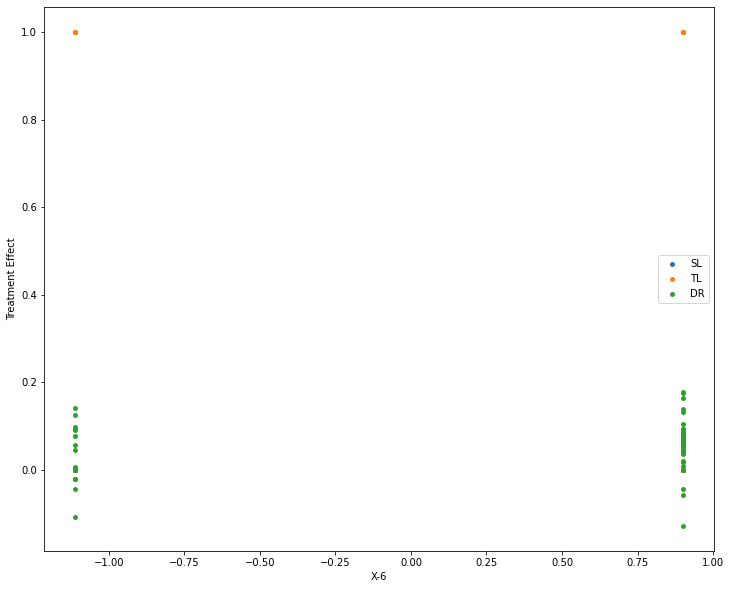

In [203]:
index = df_train.columns.get_loc('x6')

plt.figure(figsize=(12, 10))
m_size = 15
plt.scatter((x_test[:,index])[(ttestflat + e_test) > 1], avg_pred_eff_sl[(ttestflat + e_test) > 1], label="SL", s=m_size)
plt.scatter((x_test[:,index])[(ttestflat + e_test) > 1], avg_pred_eff_tl[(ttestflat + e_test) > 1], label="TL", s=m_size)
plt.scatter((x_test[:,index])[(ttestflat + e_test) > 1], dr_te_test[(ttestflat + e_test) > 1], label="DR", s=m_size)

plt.xlabel('X-6')
plt.ylabel('Treatment Effect')
plt.legend()
#plt.savefig('x6_treatmenteffect_JOBS_Scatter.png')
#files.download("x6_treatmenteffect_JOBS_Scatter.png") 

plt.show()

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

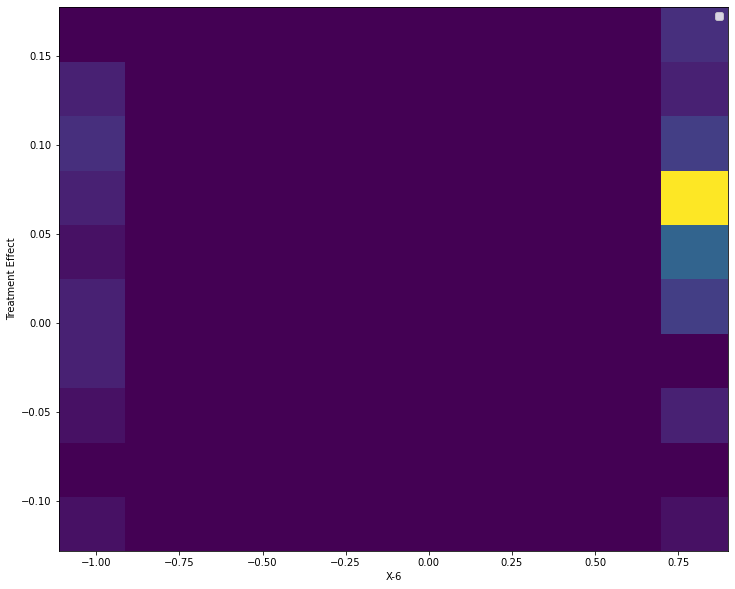

In [204]:
index = df_train.columns.get_loc('x6')

plt.figure(figsize=(12, 10))
m_size = 5
plt.hist2d((x_test[:,index])[(ttestflat + e_test) > 1], dr_te_test[(ttestflat + e_test) > 1], linewidth=0.5)


plt.xlabel('X-6')
plt.ylabel('Treatment Effect')
plt.legend()
plt.savefig('x6_treatmenteffect_JOBS_heatmap.png')
files.download("x6_treatmenteffect_JOBS_heatmap.png") 

plt.show()

In [205]:
print(len(dr_te_test[(ttestflat + e_test) > 1]))
print((x_test[:,index])[(ttestflat + e_test) > 1])

59
[ 0.90111018  0.90111018  0.90111018  0.90111018  0.90111018  0.90111018
 -1.11327681 -1.11327681 -1.11327681  0.90111018  0.90111018  0.90111018
  0.90111018  0.90111018  0.90111018  0.90111018  0.90111018 -1.11327681
  0.90111018  0.90111018  0.90111018 -1.11327681  0.90111018  0.90111018
 -1.11327681  0.90111018  0.90111018  0.90111018  0.90111018 -1.11327681
  0.90111018  0.90111018  0.90111018 -1.11327681 -1.11327681 -1.11327681
  0.90111018  0.90111018  0.90111018  0.90111018  0.90111018  0.90111018
  0.90111018  0.90111018  0.90111018  0.90111018  0.90111018  0.90111018
  0.90111018  0.90111018  0.90111018  0.90111018 -1.11327681  0.90111018
 -1.11327681  0.90111018 -1.11327681 -1.11327681  0.90111018]


In [206]:
features.append('t')
print(features)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x16', 't']


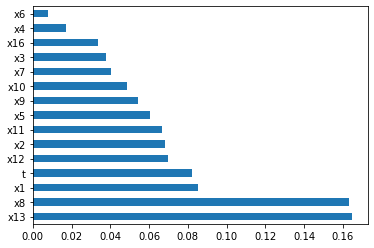

In [207]:

feat_importances = pd.Series(gbr.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')

In [208]:
print(len(avg_pred_eff_sl))
print(x_test.shape)
index = df_train.columns.get_loc('x8')

643
(643, 14)


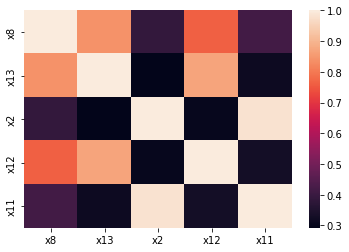

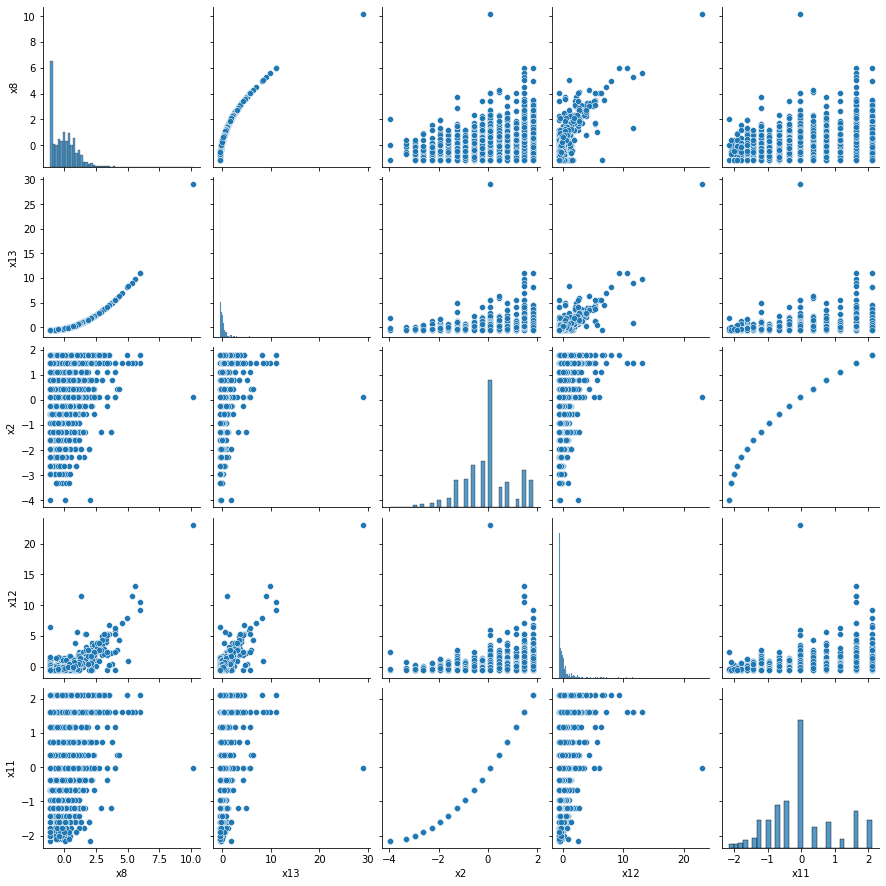

In [209]:
import seaborn as sns
features2 = ['x8', 'x13', 'x2', 'x12', 'x11']
sns.heatmap(dfraw[features2].corr())
sns.pairplot(dfraw[features2])